### OL CLL
Run correspond on cifar20 (main2.py)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/home/maitanha/cll_vlm/cll_vlm/ol_cll_logs/cifar100/cifar100_correspond.csv")

df.head

<bound method NDFrame.head of        index     true_label random_label predicted raw_answer
0          0         cattle          boy        CL         NO
1          1       dinosaur      lobster        CL         NO
2          2          apple         girl        CL         NO
3          3            boy    palm_tree        CL         NO
4          4  aquarium_fish         lamp        CL         NO
...      ...            ...          ...       ...        ...
49995  49995       squirrel       possum        OL        YES
49996  49996         beetle   chimpanzee        CL         NO
49997  49997           bear        mouse        CL         NO
49998  49998         beetle        poppy        CL         NO
49999  49999          shark         bear        CL         NO

[50000 rows x 5 columns]>

Custom Confusion Matrix:
              Predict OL  Predict CL
True Label           421          81
Random Label        3043       46455


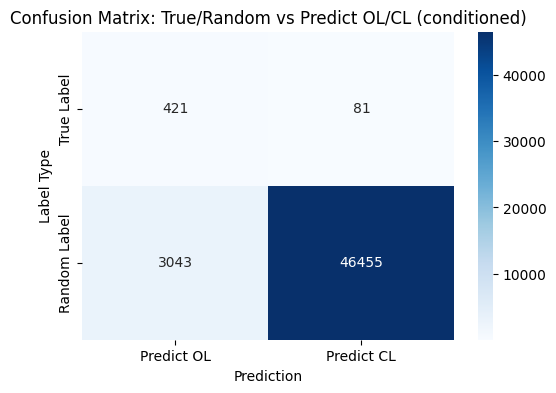

In [14]:
# Initialize counters
true_ol = true_cl = random_ol = random_cl = 0

for _, row in df.iterrows():
    same_label = (row["true_label"] == row["random_label"])
    
    if same_label:
        # Case 1: true_label == random_label
        if row["predicted"] == "OL":
            true_ol += 1
        else:  # predicted == "CL"
            true_cl += 1
    else:
        # Case 2: true_label != random_label
        if row["predicted"] == "OL":
            random_ol += 1   # model chose true
        else:  # predicted == "CL"
            random_cl += 1  # model chose random

# Build confusion matrix
matrix = pd.DataFrame(
    [[true_ol, true_cl],
     [random_ol, random_cl]],
    index=["True Label", "Random Label"],
    columns=["Predict OL", "Predict CL"]
)

print("Custom Confusion Matrix:")
print(matrix)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: True/Random vs Predict OL/CL (conditioned)")
plt.ylabel("Label Type")
plt.xlabel("Prediction")
plt.show()

In [16]:
# Accuracy cơ bản
correct = matrix.loc["True Label", "Predict OL"] + matrix.loc["Random Label", "Predict CL"]
total = matrix.values.sum()
accuracy = correct / total

print("Accuracy: {:.2f}%".format(accuracy * 100))

# Precision theo cột (định nghĩa bạn muốn)
ol_prec = matrix.loc["True Label", "Predict OL"] / (
    matrix.loc["True Label", "Predict OL"] + matrix.loc["Random Label", "Predict OL"]
)

cl_prec = matrix.loc["Random Label", "Predict CL"] / (
    matrix.loc["Random Label", "Predict CL"] + matrix.loc["True Label", "Predict CL"]
)

# Noise theo cột (false positives)
noise_ol = 1 - ol_prec
noise_cl = 1 - cl_prec

print("OL Precision: {:.2f}%".format(ol_prec * 100))
print("CL Precision: {:.2f}%".format(cl_prec * 100))
print("Noise OL: {:.2f}%".format(noise_ol * 100))
print("Noise CL: {:.2f}%".format(noise_cl * 100))


Accuracy: 93.75%
OL Precision: 12.15%
CL Precision: 99.83%
Noise OL: 87.85%
Noise CL: 0.17%


Top 10 lỗi: True != Random nhưng dự đoán OL
     true_label random_label  count
1420      trout          ray     10
1126      shark          ray     10
1291  streetcar        plain      9
1516      woman         girl      9
1083       rose        tulip      8
336   cockroach  caterpillar      8
51       beaver         bear      8
1398      train        plain      8
1225      snake      raccoon      8
71       beaver      raccoon      8


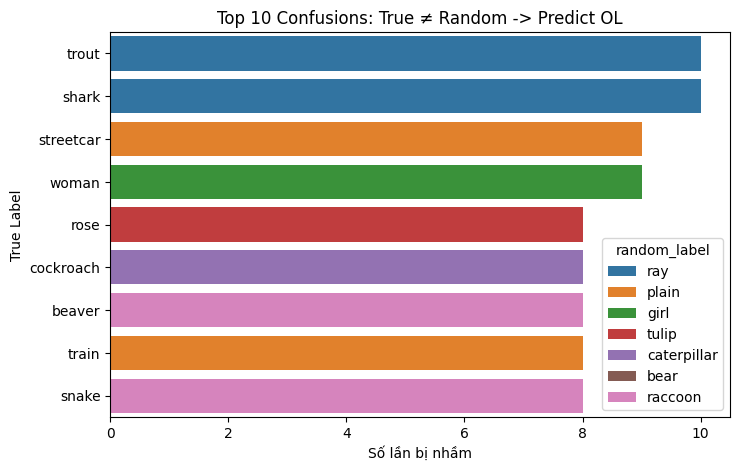

In [17]:
# --- Case 1: true != random nhưng dự đoán OL ---
errors_case1 = df[(df["true_label"] != df["random_label"]) & (df["predicted"] == "OL")]

top_confusions_case1 = (
    errors_case1.groupby(["true_label", "random_label"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(10)
)

print("Top 10 lỗi: True != Random nhưng dự đoán OL")
print(top_confusions_case1)

plt.figure(figsize=(8,5))
sns.barplot(x="count", y="true_label", hue="random_label", data=top_confusions_case1, dodge=False)
plt.title("Top 10 Confusions: True ≠ Random -> Predict OL")
plt.xlabel("Số lần bị nhầm")
plt.ylabel("True Label")
plt.show()


Top 10 lỗi: True = Random nhưng dự đoán CL
   true_label random_label  count
45       worm         worm      7
2      beaver       beaver      6
11   dinosaur     dinosaur      6
13   flatfish     flatfish      5
7       camel        camel      4
26     possum       possum      3
22      otter        otter      3
42      trout        trout      3
28        ray          ray      2
24  pine_tree    pine_tree      2


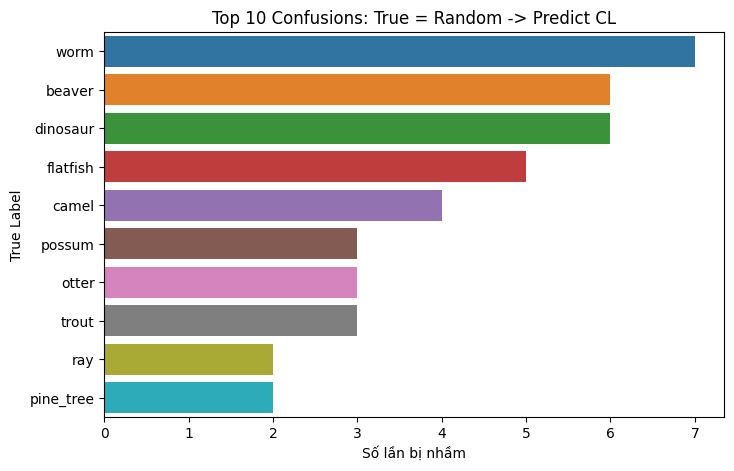

In [18]:
# --- Case 2: true == random nhưng dự đoán CL ---
errors_case2 = df[(df["true_label"] == df["random_label"]) & (df["predicted"] == "CL")]

top_confusions_case2 = (
    errors_case2.groupby(["true_label", "random_label"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(10)
)

print("\nTop 10 lỗi: True = Random nhưng dự đoán CL")
print(top_confusions_case2)

plt.figure(figsize=(8,5))
sns.barplot(x="count", y="true_label", hue="random_label", data=top_confusions_case2, dodge=False)
plt.title("Top 10 Confusions: True = Random -> Predict CL")
plt.xlabel("Số lần bị nhầm")
plt.ylabel("True Label")
plt.show()

# Chạy qua CLIP để lọc

In [1]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
from PIL import Image

from models.clip_model import CLIPModel
from models.llava_classifier import LLaVAClassifier
from dataset.cifar10 import CIFAR10Dataset
from dataset.cifar20 import CIFAR20Dataset, CIFAR100Dataset

/nfs/home/maitanha/cll_vlm/cll_vlm/vlm/CLIP


/home/maitanha/cll_vlm/venv_cll_llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 256         
num_workers = 4              # số luồng đọc dữ liệu

cifar20data = CIFAR20Dataset(
    root="/home/maitanha/cll_vlm/cll_vlm/data/cifar20",
    train=True
)
label_names = cifar20data.classes
print("Labels:", label_names)
print(f"Total samples: {len(cifar20data)}")

def collate_fn(batch):
    imgs, targets = zip(*batch)
    return list(imgs), torch.tensor(targets)

dataloader = DataLoader(cifar20data, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

Labels: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'standard transportation vehicles', 'specialized utility vehicles']
Total samples: 50000


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel(model_name="ViT-L/14@336px", device=device)
text_features = clip_model.encode_text(label_names)
text_features /= text_features.norm(dim=-1, keepdim=True)